# ***Paul SERIN***
# *HPC TOOLS : Deliverable 1*

## ***Step 1:*** Import libraries

In [1]:
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import time
from tqdm import tqdm

## ***Step 2:*** Retrieve and Store the data

Here I take and store the texts, queries and answers from the train and validation .json files. If we look carefully we will see that in these files there are a number of queries and answers for each passage. I save these informations into lists.

In [2]:
pathTrainData = "./data/train-v2.0.json"
pathTestData =  "./data/dev-v2.0.json"

def load_data(file_path):
    """Charge et retourne les contextes, questions et réponses depuis un fichier JSON."""
    with open(file_path, "r") as f:
        data = json.load(f)

    contexts = []
    questions = []
    answers = []

    for group in data['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
    
    return contexts, questions, answers

train_contexts, train_questions, train_answers = load_data(pathTrainData)
test_contexts, test_questions, test_answers = load_data(pathTestData)

## ***Step 3:*** Check the data

As you can see we have 86821 passages, queries and answers from the training data. The answer is stored in a dictionary with the specific answer in the "text" cell and the accurate character index that the answer is started in cell "answer start". As we observe, is missing the information about the exact index of the character that the answer is ending.

In [3]:
print(len(train_contexts))
print(len(train_questions))
print(len(train_answers))

86821
86821
86821


In [4]:
print("Passage: ",train_contexts[0])
print("Query: ",train_questions[0])
print("Answer: ",train_answers[0])

Passage:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Query:  When did Beyonce start becoming popular?
Answer:  {'text': 'in the late 1990s', 'answer_start': 269}


As you can see we have 20302 passages, queries and answers from the validation data

In [5]:
print(len(test_contexts))
print(len(test_questions))
print(len(test_answers))

20302
20302
20302


In [6]:
print("Passage: ",test_contexts[0])
print("Query: ",test_questions[0])
print("Answer: ",test_answers[0])

Passage:  The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Query:  In what country is Normandy located?
Answer:  {'text': 'France', 'answer_start': 159}


## ***Step 4:*** Find the end position character

Because Bert model needs both start and end position characters of the answer, I have to find it and store it for later. Sometimes, I notice that SQuAD anwers "eat" one or two characters from the real answer in the passage. For example, (as a colleague said in Piazza) for the word "sixth" in passage, SQuAD give the answer of "six". So in these cases I select to handle this problem by "cutting" the passage by 1 or 2 characters to be the same as the given answer. This strategy is because BERT works with ***tokens*** of a specific format so I needed to process the squad dataset to keep up with the input that BERT is waiting for.

Find end position character in train data

In [7]:
def adjust_answer_indices(answers, contexts):
    """
    Adjust the start and end indices of answers to ensure they correctly align
    with the context text. It handles cases where the actual answer might differ
    by one or two characters from the indexed position.
    
    Parameters:
    answers (list): List of answer dictionaries containing 'text' and 'answer_start'.
    contexts (list): List of context strings from which the answers are extracted.
    """
    for answer, context in zip(answers, contexts):
        real_answer = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(real_answer)  # Calculate the end index

        # Check if the real answer matches the exact indexed position
        if context[start_idx:end_idx] == real_answer:
            answer['answer_end'] = end_idx
        # Handle case where the real answer is off by one character
        elif context[start_idx-1:end_idx-1] == real_answer:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1
        # Handle case where the real answer is off by two characters
        elif context[start_idx-2:end_idx-2] == real_answer:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2

# Adjust the indices for both training and test sets
adjust_answer_indices(train_answers, train_contexts)
adjust_answer_indices(test_answers, test_contexts)


## ***Step 5:*** Tokenize passages and queries

In this task is asked to select the BERT-base pretrained model “bert-base-uncased” for the tokenization

In [8]:
import warnings
warnings.filterwarnings("ignore")
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(
    train_contexts, 
    train_questions, 
    truncation=True, 
    padding=True, 
    # clean_up_tokenization_spaces=True  # Delete warning
)

test_encodings = tokenizer(
    test_contexts, 
    test_questions, 
    truncation=True, 
    padding=True, 
    # clean_up_tokenization_spaces=True 
)


## ***Step 6:*** Convert the start-end positions to tokens start-end positions

In [9]:
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []

  count = 0

  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length

    # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
    if end_positions[-1] is None:
      end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
      # if end position is still None the answer passage has been truncated
      if end_positions[-1] is None:
        count += 1
        end_positions[-1] = tokenizer.model_max_length

  print(count)

  # Update the data in dictionary
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(test_encodings, test_answers)

10
16


I observed that after tokenize the end position character, sometimes was still None. This happended only for 10 answers in train data (of total 86821) and 16 answers in validation data (of total 20302). So I decided to move the answer 1 position left. If it was still None then I give them the model_max_length as before. I have to refer that I was trying to see if the answers in this case was 1 postition after (so I added +1 to the end position) or 2 positions left or right (+/- 2 positions), but the answers that there are still None was more (ie 526, while with this code there only 10). So I kept this strategy in the end, in order to have as less as possible "burned" answers.

## ***Step 7:*** Create a Dataset class

Create a Squatdataset class (inherits from torch.utils.data.Dataset), that helped me to train and validate my previous data more easily and convert encodings to datasets.

In [10]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [11]:
train_dataset = SquadDataset(train_encodings)
test_dataset = SquadDataset(test_encodings)

## ***Step 8:*** Use of DataLoader

I put my previous data to DataLoader, so as to split them in "pieces" of 8 batch size. I will explain the selection of this value of batch size later.

In [12]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

small_train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    sampler=torch.utils.data.SubsetRandomSampler(range(int(0.1 * len(train_dataset))))
)

small_test_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    sampler=torch.utils.data.SubsetRandomSampler(range(int(0.1 * len(test_dataset))))
)

## ***Step 9:*** Use GPU

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(device)}")
    print(f"GPU Device Index: {torch.cuda.current_device()}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("Using CPU")

Using GPU: NVIDIA A100-PCIE-40GB
GPU Device Index: 0
Number of GPUs: 1


## ***Step 10:*** Build the Bert model

I select BertForQuestionAnswering from transformers library, as it was the most relative with this task. When we instantiate a model with from_pretrained(), the model configuration and pre-trained weights of the specified model are used to initialize the model. Moreover, I used the PyTorch optimizer of AdamW which implements gradient bias correction as well as weight decay.



In [14]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optim = AdamW(model.parameters(), lr=5e-5)
# optim = AdamW(model.parameters(), lr=3e-5)
# optim = AdamW(model.parameters(), lr=2e-5)

epochs = 2
# epochs = 3
# epochs = 4

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This message is a warning that I should fine tune my model before I test it, in order to have a good performance.

## ***Step 11:*** Train and Evaluate Model

Training of model was done exactly as in the previous projects.

In [21]:
def train_model(model, train_loader, optimizer, device, epochs=1, print_every=500):
    """
    Train the model for a given number of epochs and print the loss during the training process.
    
    Parameters:
    - model: The model to be trained.
    - train_loader: The DataLoader for training data.
    - optimizer: Optimizer used for training.
    - device: The device (CPU/GPU) on which to train the model.
    - epochs: Number of epochs to train the model (default=1).
    - print_every: Interval of batches to print the training status (default=100).
    
    Returns:
    - train_losses: List of average losses per epoch.
    """
    model.train()
    train_losses = []
    
    total_train_time = time.time()  # Start timing the entire training process

    for epoch in range(epochs):
        epoch_time = time.time()
        total_loss = 0
        
        print(f"\n############ Train Epoch {epoch + 1} ############")
        for batch_idx, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs[0]
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if (batch_idx + 1) % print_every == 0:
                print(f"Batch {batch_idx + 1} / {len(train_loader)}, Loss: {round(loss.item(), 1)}")
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch + 1} finished. Training Loss: {avg_loss}, Time: {time.time() - epoch_time}\n")

    total_train_time = time.time() - total_train_time 
    minutes = total_train_time // 60
    seconds = total_train_time % 60
    print(f"Total Training Time: {int(minutes)} minutes {seconds:.2f} seconds")

    return train_losses


def evaluate_model(model, eval_loader, device, print_every=500):
    """
    Evaluate the model on the evaluation dataset.
    
    Parameters:
    - model: The model to be evaluated.
    - eval_loader: The DataLoader for evaluation data.
    - device: The device (CPU/GPU) on which to evaluate the model.
    - print_every: Interval of batches to print the evaluation status (default=1000).
    
    Returns:
    - eval_losses: List of average losses per evaluation.
    """
    model.eval()
    eval_losses = []
    total_loss = 0
    
    total_eval_time = time.time()  # Start timing the evaluation process
    
    print("\n############ Evaluation ############")
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(eval_loader)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs[0]
            
            total_loss += loss.item()

            if (batch_idx + 1) % print_every == 0:
                print(f"Batch {batch_idx + 1} / {len(eval_loader)}, Loss: {round(loss.item(), 1)}")
        
    avg_loss = total_loss / len(eval_loader)
    eval_losses.append(avg_loss)

    print(f"Evaluation finished.\n Validation Loss: {avg_loss}")
    total_eval_time = time.time() - total_eval_time 
    minutes = total_eval_time // 60
    seconds = total_eval_time % 60
    print(f"Total Evaluation Time: {int(minutes)} minutes {seconds:.2f} seconds")
    
    return eval_losses


def train_and_evaluate(model, train_loader, eval_loader, optimizer, device, epochs=1, print_every=500):
    """
    Train and evaluate the model.
    
    Parameters:
    - model: The model to be trained and evaluated.
    - train_loader: The DataLoader for training data.
    - eval_loader: The DataLoader for evaluation data.
    - optimizer: Optimizer used for training.
    - device: The device (CPU/GPU) on which to train and evaluate the model.
    - epochs: Number of epochs to train the model.
    - print_every: Interval of batches to print the status.
    
    Returns:
    - train_losses: List of training losses per epoch.
    - eval_losses: List of evaluation losses per epoch.
    """
    whole_train_eval_time = time.time()

    train_losses = train_model(model, train_loader, optimizer, device, epochs, print_every)
    eval_losses = evaluate_model(model, eval_loader, device, print_every)
    
    print(f"Total training and evaluation time: {time.time() - whole_train_eval_time}\n")
    
    return train_losses, eval_losses


In [16]:
train_losses = train_model(model, train_loader, optim, device, epochs=2)


############ Train Epoch 1 ############


  5%|█████████▍                                                                                                                                                                                                  | 501/10853 [01:27<30:04,  5.74it/s]

Batch 500 / 10853, Loss: 2.3


  9%|██████████████████▋                                                                                                                                                                                        | 1001/10853 [02:54<28:42,  5.72it/s]

Batch 1000 / 10853, Loss: 1.0


 14%|████████████████████████████                                                                                                                                                                               | 1501/10853 [04:21<27:13,  5.73it/s]

Batch 1500 / 10853, Loss: 1.7


 18%|█████████████████████████████████████▍                                                                                                                                                                     | 2001/10853 [05:48<25:46,  5.72it/s]

Batch 2000 / 10853, Loss: 3.1


 23%|██████████████████████████████████████████████▊                                                                                                                                                            | 2501/10853 [07:16<24:19,  5.72it/s]

Batch 2500 / 10853, Loss: 1.2


 28%|████████████████████████████████████████████████████████▏                                                                                                                                                  | 3001/10853 [08:43<22:53,  5.71it/s]

Batch 3000 / 10853, Loss: 0.8


 32%|█████████████████████████████████████████████████████████████████▍                                                                                                                                         | 3501/10853 [10:11<21:23,  5.73it/s]

Batch 3500 / 10853, Loss: 1.6


 37%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 4001/10853 [11:38<19:55,  5.73it/s]

Batch 4000 / 10853, Loss: 2.1


 41%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 4501/10853 [13:05<18:29,  5.72it/s]

Batch 4500 / 10853, Loss: 1.3


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 5001/10853 [14:33<17:02,  5.72it/s]

Batch 5000 / 10853, Loss: 0.3


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 5501/10853 [16:00<15:35,  5.72it/s]

Batch 5500 / 10853, Loss: 1.3


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 6001/10853 [17:28<14:07,  5.72it/s]

Batch 6000 / 10853, Loss: 2.1


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 6501/10853 [18:55<12:41,  5.72it/s]

Batch 6500 / 10853, Loss: 0.9


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 7001/10853 [20:22<11:13,  5.72it/s]

Batch 7000 / 10853, Loss: 1.8


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 7501/10853 [21:50<09:45,  5.72it/s]

Batch 7500 / 10853, Loss: 1.2


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 8001/10853 [23:17<08:18,  5.72it/s]

Batch 8000 / 10853, Loss: 1.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 8501/10853 [24:45<06:51,  5.72it/s]

Batch 8500 / 10853, Loss: 1.9


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 9001/10853 [26:12<05:23,  5.72it/s]

Batch 9000 / 10853, Loss: 0.8


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 9501/10853 [27:39<03:56,  5.72it/s]

Batch 9500 / 10853, Loss: 1.7


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 10001/10853 [29:07<02:28,  5.72it/s]

Batch 10000 / 10853, Loss: 1.1


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 10501/10853 [30:34<01:01,  5.73it/s]

Batch 10500 / 10853, Loss: 2.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10853/10853 [31:35<00:00,  5.72it/s]


Epoch 1 finished. Training Loss: 1.3289806868046548, Time: 1896.0015404224396


############ Train Epoch 2 ############


  5%|█████████▍                                                                                                                                                                                                  | 501/10853 [01:27<30:09,  5.72it/s]

Batch 500 / 10853, Loss: 1.2


  9%|██████████████████▋                                                                                                                                                                                        | 1001/10853 [02:54<28:42,  5.72it/s]

Batch 1000 / 10853, Loss: 0.5


 14%|████████████████████████████                                                                                                                                                                               | 1501/10853 [04:22<27:12,  5.73it/s]

Batch 1500 / 10853, Loss: 1.2


 18%|█████████████████████████████████████▍                                                                                                                                                                     | 2001/10853 [05:49<25:45,  5.73it/s]

Batch 2000 / 10853, Loss: 0.4


 23%|██████████████████████████████████████████████▊                                                                                                                                                            | 2501/10853 [07:17<24:19,  5.72it/s]

Batch 2500 / 10853, Loss: 0.7


 28%|████████████████████████████████████████████████████████▏                                                                                                                                                  | 3001/10853 [08:44<22:49,  5.73it/s]

Batch 3000 / 10853, Loss: 0.8


 32%|█████████████████████████████████████████████████████████████████▍                                                                                                                                         | 3501/10853 [10:11<21:21,  5.74it/s]

Batch 3500 / 10853, Loss: 1.0


 37%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 4001/10853 [11:38<19:55,  5.73it/s]

Batch 4000 / 10853, Loss: 1.2


 41%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 4501/10853 [13:06<18:29,  5.73it/s]

Batch 4500 / 10853, Loss: 0.4


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 5001/10853 [14:33<17:02,  5.72it/s]

Batch 5000 / 10853, Loss: 0.9


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 5501/10853 [16:00<15:34,  5.73it/s]

Batch 5500 / 10853, Loss: 0.6


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 6001/10853 [17:28<14:07,  5.73it/s]

Batch 6000 / 10853, Loss: 1.2


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 6501/10853 [18:55<12:40,  5.72it/s]

Batch 6500 / 10853, Loss: 1.3


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 7001/10853 [20:22<11:12,  5.72it/s]

Batch 7000 / 10853, Loss: 0.9


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 7501/10853 [21:50<09:45,  5.73it/s]

Batch 7500 / 10853, Loss: 1.0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 8001/10853 [23:17<08:18,  5.72it/s]

Batch 8000 / 10853, Loss: 0.5


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 8501/10853 [24:44<06:50,  5.73it/s]

Batch 8500 / 10853, Loss: 1.0


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 9001/10853 [26:12<05:23,  5.73it/s]

Batch 9000 / 10853, Loss: 0.3


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 9501/10853 [27:39<03:56,  5.72it/s]

Batch 9500 / 10853, Loss: 1.2


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 10001/10853 [29:06<02:28,  5.73it/s]

Batch 10000 / 10853, Loss: 1.3


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 10501/10853 [30:34<01:01,  5.72it/s]

Batch 10500 / 10853, Loss: 0.7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10853/10853 [31:35<00:00,  5.72it/s]

Epoch 2 finished. Training Loss: 0.8746673937663497, Time: 1895.772430896759

Total Training Time: 63 minutes 11.77 seconds


In [22]:
test_losses = evaluate_model(model, test_loader, device)


############ Evaluation ############


 20%|████████████████████████████████████████▌                                                                                                                                                                    | 502/2538 [00:27<01:51, 18.28it/s]

Batch 500 / 2538, Loss: 1.1


 39%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 1002/2538 [00:54<01:24, 18.24it/s]

Batch 1000 / 2538, Loss: 0.4


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1502/2538 [01:22<00:56, 18.22it/s]

Batch 1500 / 2538, Loss: 1.2


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 2002/2538 [01:49<00:29, 18.22it/s]

Batch 2000 / 2538, Loss: 1.9


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2502/2538 [02:17<00:01, 18.22it/s]

Batch 2500 / 2538, Loss: 1.9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2538/2538 [02:18<00:00, 18.26it/s]

Evaluation finished.
 Validation Loss: 1.2012053896005905
Total Evaluation Time: 2 minutes 18.97 seconds


# Step 12: Print results

In [25]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, test_losses=None):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss", color='b')
    
    if test_losses:
        plt.plot(test_losses, label="Validation Loss", color='r')
    
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

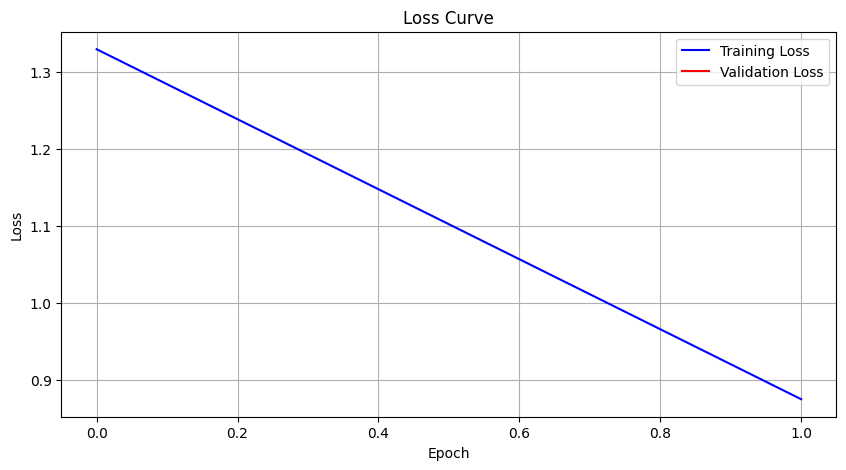

In [26]:
plot_losses(train_losses, test_losses)